In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    f1_score
)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


In [2]:
DATA_PROCESSED = Path("../data/processed")

# If you used CSV:
df = pd.read_csv(DATA_PROCESSED / "city_day_merged.csv", parse_dates=["Date"])

# If you used Parquet instead:
# df = pd.read_parquet(DATA_PROCESSED / "city_day_merged.parquet")

df = df.sort_values("Date").reset_index(drop=True)
df.head()


,City,State,Date,AccidentCount,AverageSeverity,MaxSeverity,HighSeverityFlag,Temperature,Precipitation,Is_Holiday,Year,Month,DayOfWeek,is_weekend,Season,is_rainy,AccidentCount_lag1,AccidentCount_7d_ma
0,Indianapolis,IN,2016-02-09,1,2.000000,2,0,NaN,NaN,0,2016,2,1,0,Winter,0,NaN,1.0
1,Indianapolis,IN,2016-02-15,1,4.000000,4,1,NaN,NaN,1,2016,2,0,0,Winter,0,1.0,1.0
2,Indianapolis,IN,2016-03-10,4,2.000000,2,0,NaN,NaN,0,2016,3,3,0,Spring,0,1.0,2.0
3,Los Angeles,CA,2016-03-22,5,2.400000,3,1,NaN,NaN,0,2016,3,1,0,Spring,0,NaN,5.0
4,Philadelphia,PA,2016-03-23,6,2.333333,4,1,NaN,NaN,0,2016,3,2,0,Spring,0,NaN,6.0


In [3]:
print(df.shape)
print(df.columns.tolist())

# Missingness (top 20)
df.isna().mean().sort_values(ascending=False).head(20)


(5525, 18)
['City', 'State', 'Date', 'AccidentCount', 'AverageSeverity', 'MaxSeverity', 'HighSeverityFlag', 'Temperature', 'Precipitation', 'Is_Holiday', 'Year', 'Month', 'DayOfWeek', 'is_weekend', 'Season', 'is_rainy', 'AccidentCount_lag1', 'AccidentCount_7d_ma']


Temperature            1.00000
Precipitation          1.00000
AccidentCount_lag1     0.00181
City                   0.00000
Year                   0.00000
is_rainy               0.00000
Season                 0.00000
is_weekend             0.00000
DayOfWeek              0.00000
Month                  0.00000
Is_Holiday             0.00000
State                  0.00000
HighSeverityFlag       0.00000
MaxSeverity            0.00000
AverageSeverity        0.00000
AccidentCount          0.00000
Date                   0.00000
AccidentCount_7d_ma    0.00000
dtype: float64

Targets + feature list

In [4]:
TARGET_CLS = "HighSeverityFlag"
TARGET_REG = "AccidentCount"

# Core feature list; keep only columns that exist
candidate_features = [
    # calendar
    "Month", "DayOfWeek", "is_weekend", "Is_Holiday", "Season",

    # weather (may be dropped later if entirely missing)
    "Temperature", "Precipitation",
    "is_rainy", "is_snowy", "low_visibility",

    # lagged / history
    "AccidentCount_lag1", "AccidentCount_7d_ma",
]

features = [c for c in candidate_features if c in df.columns]
print("Features used:", features)

# Drop rows missing targets
df = df.dropna(subset=[TARGET_CLS, TARGET_REG]).copy()

# Ensure cls target is int
df[TARGET_CLS] = df[TARGET_CLS].astype(int)

df[[TARGET_CLS, TARGET_REG]].head()


Features used: ['Month', 'DayOfWeek', 'is_weekend', 'Is_Holiday', 'Season', 'Temperature', 'Precipitation', 'is_rainy', 'AccidentCount_lag1', 'AccidentCount_7d_ma']


,HighSeverityFlag,AccidentCount
0,0,1
1,1,1
2,0,4
3,1,5
4,1,6


Time-based split

In [5]:
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print("Train:", train_df["Date"].min(), "→", train_df["Date"].max(), "| rows:", len(train_df))
print("Test: ", test_df["Date"].min(), "→", test_df["Date"].max(), "| rows:", len(test_df))

X_train = train_df[features].copy()
X_test = test_df[features].copy()

y_train_cls = train_df[TARGET_CLS].astype(int)
y_test_cls = test_df[TARGET_CLS].astype(int)

y_train_reg = train_df[TARGET_REG].astype(float)
y_test_reg = test_df[TARGET_REG].astype(float)

print("Class balance (test):")
print(y_test_cls.value_counts(normalize=True))


Train: 2016-02-09 00:00:00 → 2021-09-08 00:00:00 | rows: 4420
Test:  2021-09-08 00:00:00 → 2021-12-31 00:00:00 | rows: 1105
Class balance (test):
HighSeverityFlag
1    0.917647
0    0.082353
Name: proportion, dtype: float64


all-NaN columns

In [6]:
def drop_all_nan_columns(X_train_in: pd.DataFrame, X_test_in: pd.DataFrame):
    X_train_out = X_train_in.copy()
    X_test_out = X_test_in.copy()

    all_nan_cols = [c for c in X_train_out.columns if X_train_out[c].isna().all()]
    if all_nan_cols:
        print("Dropping all-NaN columns:", all_nan_cols)
        X_train_out = X_train_out.drop(columns=all_nan_cols)
        X_test_out = X_test_out.drop(columns=all_nan_cols)

    return X_train_out, X_test_out, all_nan_cols


def build_preprocess(X_train_in: pd.DataFrame):
    categorical_cols = [c for c in X_train_in.columns if X_train_in[c].dtype == "object"]
    numeric_cols = [c for c in X_train_in.columns if c not in categorical_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
            ]), numeric_cols),

            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical_cols),
        ],
        remainder="drop"
    )
    return preprocess, numeric_cols, categorical_cols


Logistic Regression

In [7]:
# 4A: Logistic Regression with imbalance handling + threshold tuning

X_train_fix, X_test_fix, dropped_cols = drop_all_nan_columns(X_train, X_test)
preprocess_fix, numeric_cols, categorical_cols = build_preprocess(X_train_fix)

clf_lr = Pipeline(steps=[
    ("prep", preprocess_fix),
    ("model", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

clf_lr.fit(X_train_fix, y_train_cls)

proba = clf_lr.predict_proba(X_test_fix)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test_cls, proba))
print("PR-AUC: ", average_precision_score(y_test_cls, proba))

# Threshold tuning (macro-F1)
thresholds = np.linspace(0.05, 0.95, 19)
best_t, best_macro_f1 = 0.5, -1

for t in thresholds:
    preds = (proba >= t).astype(int)
    score = f1_score(y_test_cls, preds, average="macro", zero_division=0)
    if score > best_macro_f1:
        best_macro_f1 = score
        best_t = t

print("Best threshold:", best_t)
print("Best macro-F1:", best_macro_f1)

pred_best = (proba >= best_t).astype(int)

print(classification_report(y_test_cls, pred_best, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, pred_best))


Dropping all-NaN columns: ['Temperature', 'Precipitation']
ROC-AUC: 0.706320306912023
PR-AUC:  0.9597703112819134
Best threshold: 0.35
Best macro-F1: 0.6129547900626022
              precision    recall  f1-score   support

           0       0.25      0.41      0.31        91
           1       0.94      0.89      0.92      1014

    accuracy                           0.85      1105
   macro avg       0.60      0.65      0.61      1105
weighted avg       0.89      0.85      0.87      1105

Confusion Matrix:
 [[ 37  54]
 [111 903]]


RandomForestClassifier

In [8]:
X_train_fix, X_test_fix, dropped_cols = drop_all_nan_columns(X_train, X_test)
preprocess_fix, numeric_cols, categorical_cols = build_preprocess(X_train_fix)

clf_rf = Pipeline(steps=[
    ("prep", preprocess_fix),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

clf_rf.fit(X_train_fix, y_train_cls)
proba_rf = clf_rf.predict_proba(X_test_fix)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test_cls, proba_rf))
print("PR-AUC: ", average_precision_score(y_test_cls, proba_rf))

thresholds = np.linspace(0.05, 0.95, 19)
best_t_rf, best_macro_f1_rf = 0.5, -1

for t in thresholds:
    preds = (proba_rf >= t).astype(int)
    score = f1_score(y_test_cls, preds, average="macro", zero_division=0)
    if score > best_macro_f1_rf:
        best_macro_f1_rf = score
        best_t_rf = t

print("Best threshold:", best_t_rf)
print("Best macro-F1:", best_macro_f1_rf)

pred_rf_best = (proba_rf >= best_t_rf).astype(int)

print(classification_report(y_test_cls, pred_rf_best, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, pred_rf_best))


Dropping all-NaN columns: ['Temperature', 'Precipitation']
ROC-AUC: 0.5908273186379696
PR-AUC:  0.9402537530202338
Best threshold: 0.7
Best macro-F1: 0.5284564977786155
              precision    recall  f1-score   support

           0       0.13      0.14      0.14        91
           1       0.92      0.92      0.92      1014

    accuracy                           0.85      1105
   macro avg       0.53      0.53      0.53      1105
weighted avg       0.86      0.85      0.85      1105

Confusion Matrix:
 [[ 13  78]
 [ 85 929]]


RF feature importances

In [9]:
# Extract feature names after preprocessing
prep = clf_rf.named_steps["prep"]
model = clf_rf.named_steps["model"]

feature_names = list(numeric_cols)

if len(categorical_cols) > 0:
    ohe = prep.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names += ohe_names

importances = model.feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

fi.head(20)


,feature,importance
6,AccidentCount_7d_ma,0.461313
5,AccidentCount_lag1,0.289290
1,DayOfWeek,0.103253
0,Month,0.085755
2,is_weekend,0.014771
3,Is_Holiday,0.012571
8,Season_Spring,0.008508
10,Season_Winter,0.008449
9,Season_Summer,0.008353
7,Season_Fall,0.007737


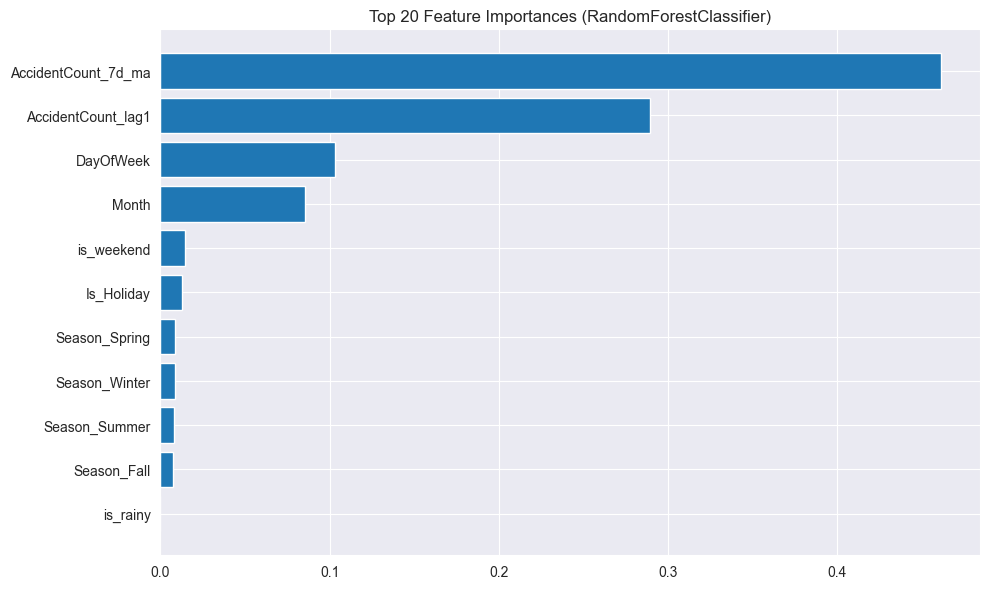

In [10]:
top_fi = fi.head(20).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top_fi["feature"], top_fi["importance"])
plt.title("Top 20 Feature Importances (RandomForestClassifier)")
plt.tight_layout()
plt.show()


Linear Regression

In [12]:
import sklearn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pred_reg = reg_lr.predict(X_test_fix)

mae = mean_absolute_error(y_test_reg, pred_reg)
mse = mean_squared_error(y_test_reg, pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, pred_reg)

print("scikit-learn version:", sklearn.__version__)
print("Linear Regression")
print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


scikit-learn version: 1.6.1
Linear Regression
MAE : 12.546928304667334
RMSE: 19.350083576145767
R2  : 0.7457542937334554


Random Forest Regressor

In [14]:
X_train_fix, X_test_fix, dropped_cols = drop_all_nan_columns(X_train, X_test)
preprocess_fix, numeric_cols, categorical_cols = build_preprocess(X_train_fix)

reg_rf = Pipeline(steps=[
    ("prep", preprocess_fix),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

reg_rf.fit(X_train_fix, y_train_reg)
pred_reg_rf = reg_rf.predict(X_test_fix)

mae = mean_absolute_error(y_test_reg, pred_reg_rf)
rmse = mean_squared_error(y_test_reg, pred_reg_rf)
r2 = r2_score(y_test_reg, pred_reg_rf)

print("Random Forest Regressor")
print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)


Dropping all-NaN columns: ['Temperature', 'Precipitation']
Random Forest Regressor
MAE : 11.421842948228242
RMSE: 316.445481634496
R2  : 0.7851245318350716


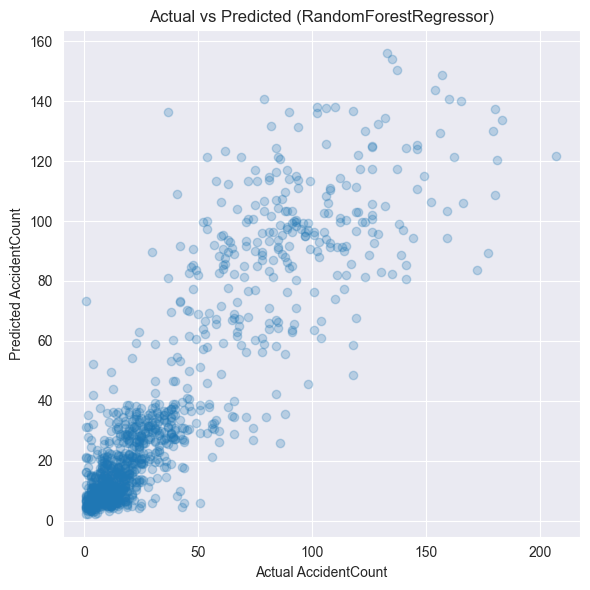

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, pred_reg_rf, alpha=0.25)
plt.xlabel("Actual AccidentCount")
plt.ylabel("Predicted AccidentCount")
plt.title("Actual vs Predicted (RandomForestRegressor)")
plt.tight_layout()
plt.show()


In [17]:
import joblib

ARTIFACTS = Path("../reports/artifacts")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

joblib.dump(clf_lr, ARTIFACTS / "logreg_classifier.joblib")
joblib.dump(clf_rf, ARTIFACTS / "rf_classifier.joblib")
joblib.dump(reg_lr, ARTIFACTS / "linear_regressor.joblib")
joblib.dump(reg_rf, ARTIFACTS / "rf_regressor.joblib")

print(" Saved models to:", ARTIFACTS.resolve())


 Saved models to: /Users/alputar/Desktop/dsa210ubartu/reports/artifacts
